In [0]:
import PIL
from PIL import Image

import random
from matplotlib import pyplot as plt
from os import listdir, path
import os

from torch import nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from glob import glob
import torch
import numpy as np

from torchvision.transforms.transforms import Compose, Resize, ToTensor, CenterCrop
import time

import cv2


import warnings
warnings.filterwarnings('ignore')
import random
import skimage
from skimage import io
from skimage.transform import rotate, AffineTransform, warp
from skimage import util
from skimage.filters import gaussian


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
IMG_SIZE = 224

In [0]:
def show_sample_images(root_dir='data', sample_size=10, from_class=None):    
    '''
    This function samples images from input data and shows them in a plot.
    Samples are with replacement out of the given class. If no class is given,
    samples are extracted from random classes.
    '''
    
    # number of images on the x and y axes should be relatively close
    for i in range(int(sample_size**0.5 + 1), 0, -1):
        if sample_size % i == 0:
            N_images_x = i
            N_images_y = int(sample_size/N_images_x)
            break
    
    # sample data directory and show image in subplots
    fig, ax = plt.subplots(N_images_x, N_images_y, squeeze=False)
    for sample_number in range(sample_size):
        if not from_class:
            dic = path.join(root_dir, 'images_200')
            labels_list = listdir(dic)
            label = str(random.sample(labels_list, 1)[0])
        
        parent_directory = path.join(root_dir, 'images_200', label)
        file_list = listdir(parent_directory)
        file_name = random.sample(file_list, 1)[0]
        img = Image.open(path.join(parent_directory, file_name))

        ax[sample_number % N_images_x][sample_number // N_images_x].imshow(img)
        ax[sample_number % N_images_x][sample_number // N_images_x].title.set_text(label)
        
    fig.set_figheight(N_images_y * 4)
    fig.set_figwidth(N_images_y * 4)
    fig.show()

In [0]:
#show_sample_images('drive/My Drive/503 project dataset', 20) # use for show the image

from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
 
dog = imread('drive/My Drive/503 project dataset/images_200/Titian/Titian_1.jpg')#, as_grey=True)
# https://en.wikipedia.org/wiki/German_Shepherd#/media/File:Kim_at_14_weeks.jpg
 
# scale down the image to one third
dog = rescale(dog, 1/3, mode='reflect')
# calculate the hog and return a visual representation.
dog_hog, dog_hog_img = hog(
    dog, pixels_per_cell=(12, 12),
    cells_per_block=(2,2),
    orientations=8,
    #visualise=True,
    block_norm='L2-Hys')
 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,6)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    for a in ax]
 
ax[0].imshow(dog, cmap='gray')
ax[0].set_title('dog')
ax[1].imshow(dog_hog_img, cmap='gray')
ax[1].set_title('hog')
plt.show()

ValueError: ignored

In [0]:
# define a very small model (~400k parameters) that can work, improvements may be made later
class TinyModel(nn.Module):
    
    def __init__(self):
        super(TinyModel, self).__init__()
        self.bn1 = nn.BatchNorm2d(3)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=(5, 5))
        self.bn2 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(in_channels=10 , out_channels=10, kernel_size=(5, 5), stride=2)
        self.fc1 = nn.Linear(4410, 120)
        self.fc2 = nn.Linear(120, 11)
        
    def forward(self, x):
        x = F.relu(self.conv1(self.bn1(x)))
        x = F.relu(self.conv2(self.bn2(x)))
        x = x.view(-1, 4410)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)
    
    def loss(self, prediction, true_values):

        return F.nll_loss(prediction, true_values)

In [0]:
print(PIL.PILLOW_VERSION)


7.1.1


In [0]:
def rotate(image, angle=90, scale=1.0):
    '''
    Rotate the image
    :param image: image to be processed
    :param angle: Rotation angle in degrees. Positive values mean counter-clockwise rotation (the coordinate origin is assumed to be the top-left corner).
    :param scale: Isotropic scale factor.
    '''
    w = image.shape[1]
    h = image.shape[0]
    #rotate matrix
    M = cv2.getRotationMatrix2D((w/2,h/2), angle, scale)
    #rotate
    image = cv2.warpAffine(image,M,(w,h))
    return image

def split_train_test(root_dir, train_dir, test_dir):
    all_labels = listdir(path.join(root_dir, 'images_200'))
    all_data = []
    target_size = 800
    # Create a list of tuples out of data samples. Each tuple includes images file name and an int as label code
    for label_code, parent_dir in enumerate(all_labels):
        name_list = []
        parent_directory = path.join(root_dir, 'images_200', parent_dir)
        file_list = listdir(parent_directory)
        random.shuffle(file_list)
        for test_sample in file_list[:40]:
            img = cv2.imread(path.join(parent_directory, test_sample))
            cv2.imwrite(path.join(test_dir, parent_dir, test_sample), img)

        origin_size = len(file_list) - 40
        choose = min(int((target_size - origin_size)/3), origin_size)
        for addi in file_list[80:80+choose]:
            img = cv2.imread(path.join(parent_directory, addi))

            angle = np.random.uniform(45,180,1)
            scale = np.random.uniform(1,2,1)
            flipped_img = np.fliplr(img)
            rotated_img = rotate(img, angle=angle, scale=scale)

            angle = np.random.uniform(45,180,1)
            scale = np.random.uniform(1,2,1)
            rotated_img2 = rotate(img, angle=angle, scale=scale)

            cv2.imwrite(path.join(train_dir, parent_dir, addi), img)
            cv2.imwrite(path.join(train_dir, parent_dir, addi[:len(addi)-4]+"_flip.png"), flipped_img)
            cv2.imwrite(path.join(train_dir, parent_dir, addi[:len(addi)-4]+"_rotate.png"), rotated_img)
            cv2.imwrite(path.join(train_dir, parent_dir, addi[:len(addi)-4]+"_rotate2.png"), rotated_img2)

        for rest in file_list[80+choose:]:
            img = cv2.imread(path.join(parent_directory, rest))
            cv2.imwrite(path.join(train_dir, parent_dir, rest), img)

        if 4*origin_size < target_size:
            choose2 = min(int(target_size-4*origin_size), origin_size)
            for add2 in file_list[80:80+choose2]:
                angle = np.random.uniform(45,180,1)
                scale = np.random.uniform(1,2,1)
                img = cv2.imread(path.join(parent_directory, add2))
                rotated_img3 = rotate(img, angle=angle, scale=scale)
                cv2.imwrite(path.join(train_dir, parent_dir, add2[:len(add2)-4]+"_rotate3.png"), rotated_img3)


def split_train_test2(root_dir, train_dir, test_dir):
    all_labels = listdir(path.join(root_dir, 'images_200'))
    all_data = []
    target_size = 800
    # Create a list of tuples out of data samples. Each tuple includes images file name and an int as label code
    for label_code, parent_dir in enumerate(all_labels):
        name_list = []
        parent_directory = path.join(root_dir, 'images_200', parent_dir)
        file_list = listdir(parent_directory)
        random.shuffle(file_list)
        for test_sample in file_list[:40]:
            img = cv2.imread(path.join(parent_directory, test_sample))
            cv2.imwrite(path.join(test_dir, parent_dir, test_sample), img)
        for train_sample in file_list[40:]:
            img = cv2.imread(path.join(parent_directory, train_sample))
            cv2.imwrite(path.join(train_dir, parent_dir, train_sample), img)            
#split_train_test2('drive/My Drive/503 project dataset', 'drive/My Drive/503 project dataset/train_test_split/train', 'drive/My Drive/503 project dataset/train_test_split/test')

In [0]:
# define a class for the dataset
class SeedlingDataset(Dataset):
    
    def __init__(self, data, n_labels, transform=None):
        
        self.data = data
        self.transform = transform
        self.n_labels = n_labels
        self.transform = transform
        
    def __len__(self):
        
        return len(self.data)
    
    def __getitem__(self, idx):
        
        data_file, image_code = self.data[idx]
        img = Image.open(data_file)
        img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)
        img = torch.from_numpy(np.array(img))
        label = torch.tensor(image_code)
        
        return img, label
    
def getDataLoaders_split(train_dir, train_transforms, batch_size, randomsh = True):
    all_labels = listdir(train_dir)
    all_data = []
    for label_code, parent_dir in enumerate(all_labels):
        this_dir_images = glob(path.join(train_dir, parent_dir, '*.png'))
        all_data += zip(this_dir_images, [label_code]*len(this_dir_images))
    if randomsh:
        random.shuffle(all_data)
    train_data = SeedlingDataset(all_data, len(all_labels), transform=train_transforms)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=randomsh, num_workers=0)
    return train_loader

def getDataLoaders_fix(root_dir, train_transforms, test_transform, batch_size, train_path, test_path):
    all_labels = listdir(path.join(root_dir, 'images_200'))
    test_data = SeedlingDataset(test_path, len(all_labels), transform=test_transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=0)

    train_data = SeedlingDataset(train_path, len(all_labels), transform=train_transforms)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
    return train_loader, test_loader, train_path, test_path


def getDataLoaders(root_dir, train_transforms,test_transform, batch_size, test_ratio=0.2):
    
    '''
    This function defines train and test data loaders for the Seedling class of data.
    test_ratio is the ratio of the number of test images to the total number of images.
    '''
    
    all_labels = listdir(root_dir)
    all_data = []
    
    # Create a list of tuples out of data samples. Each tuple includes images file name and an int as label code
    for label_code, parent_dir in enumerate(all_labels):
        this_dir_images = glob(path.join(root_dir, parent_dir, '*.jpg'))
        all_data += zip(this_dir_images, [label_code]*len(this_dir_images))
    
    # Shuffle data and create train and test parts
    random.shuffle(all_data)
    n_train_examples = int(len(all_data) * (1 - test_ratio))
    test_data = SeedlingDataset(all_data[n_train_examples:], len(all_labels), transform=test_transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=0)

    all_data = all_data[:n_train_examples]
    random.shuffle(all_data)
    train_data = SeedlingDataset(all_data, len(all_labels), transform=train_transforms)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)

    return train_loader, test_loader

In [0]:
def train(model, device, train_dataloader, optimizer, epoch, verbose=False):
    
    model.train()
    total_loss = 0
    for batch_idx, (image, label) in enumerate(train_dataloader):
        input_var = image.to(device)
        target_var = label.to(device)
        optimizer.zero_grad()
        output = model(input_var)
        loss = model.loss(output, target_var)
        loss.backward()
        optimizer.step()
        total_loss += loss
        if batch_idx % 10 == 0 and verbose:
            print('Train Epoch: {0}, Train batch: {1}, Batch loss: {2}'
                  .format(epoch, batch_idx, loss))
    
    epoch_loss = total_loss/(batch_idx + 1)
    
    return epoch_loss
    
    
def test(model, device, test_dataloader):
    
    model.eval()
    correct = 0
    with torch.no_grad():
        for image, label in test_dataloader:
            input_var = image.to(device)
            target_var = label.to(device)
            output = model(input_var)
            prediction = output.argmax(dim=1, keepdim=True)
            correct += prediction.eq(target_var.view_as(prediction)).sum().item()
        accuracy = correct / len(test_dataloader.dataset)
    
    return accuracy

In [0]:
def AdjustLR(optim, lr):
    '''
    This is a simple hand-made function to decrease 
    optimizer's learning rate by a factor of 10 at a specific time
    '''
    for param_group in optim.param_groups:
            param_group['lr'] /= 10

In [0]:
model = models.densenet161(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth


In [0]:
# 换了个模型试试 model2
import random
model = models.densenet161(pretrained=True)

random.seed(30)

from torchvision import datasets, transforms,models

for param in model.parameters():
    param.requires_grad = False
import torch.nn as nn
from collections import OrderedDict

train_transform = Compose([Resize(256), CenterCrop(256), ToTensor()])
train_loader, test_loader = getDataLoaders('drive/My Drive/503 project dataset/train_test_split/train', train_transform, train_transform, batch_size=64, test_ratio=0.2)

classifier = nn.Sequential(
  nn.Linear(in_features=2208, out_features=2208),
  nn.ReLU(),
  nn.Dropout(p=0.4),
  nn.Linear(in_features=2208, out_features=1024),
  nn.ReLU(),
  nn.Dropout(p=0.3),
  nn.Linear(in_features=1024, out_features=11),
  nn.LogSoftmax(dim=1)  
)
    
model.classifier = classifier

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
model = model.to(device)

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.003)
# turn this off
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
import time

def train_model(model,
                train_loader,
                valid_loader,
                n_epochs,
                optimizer,
                scheduler,
                criterion,
                name="model.pt",
                path=None):
    # compare overfited
    train_loss_data, valid_loss_data = [], []
    # check for validation loss
    valid_loss_min = np.Inf
    # calculate time
    since = time.time()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    accuracy_min = 80

    for epoch in range(n_epochs):
        print("Epoch: {}/{}".format(epoch + 1, n_epochs))
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0
        total = 0
        correct = 0
        e_since = time.time()

        ###################
        # train the model #
        ###################
        model.train()  # prep model for training
        scheduler.step()  # step up scheduler
        for images, labels in train_loader:
            # Move input and label tensors to the default device
            images, labels = images.to(device), labels.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            log_ps = model(images)
            # calculate the loss
            loss = criterion(log_ps, labels)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item() * images.size(0)

        ######################
        # validate the model #
        ######################
        print("\t\tGoing for validation")
        model.eval()  # prep model for evaluation
        for data, target in test_loader:
            # Move input and label tensors to the default device
            data, target = data.to(device), target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss_p = criterion(output, target)
            # update running validation loss
            valid_loss += loss_p.item() * data.size(0)
            # calculate accuracy
            proba = torch.exp(output)
            top_p, top_class = proba.topk(1, dim=1)
            equals = top_class == target.view(*top_class.shape)

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

        # print training/validation statistics
        # calculate average loss over an epoch
        train_loss = train_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(test_loader.dataset)

        # calculate train loss and running loss
        train_loss_data.append(train_loss * 100)
        valid_loss_data.append(valid_loss * 100)

        print("\tTrain loss:{:.6f}..".format(train_loss),
              "\tValid Loss:{:.6f}..".format(valid_loss),
              "\tAccuracy: {:.4f}".format(correct / total * 100))

        # Time take for one epoch
        time_elapsed = time.time() - e_since
        print('\tEpoch:{} completed in {:.0f}m {:.0f}s'.format(
            epoch + 1, time_elapsed // 60, time_elapsed % 60))

    # compare total time
    time_elapsed = time.time() - since
    print('Training completed in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # return the model
    return [model, train_loss_data, valid_loss_data]
total_epoch = 10
model, train_loss, valid_loss = train_model(model, train_loader,
          test_loader, total_epoch, optimizer,scheduler, criterion)



In [0]:
fig, ax1 = plt.subplots(figsize=(8,4))

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training loss', color='r')
ax1.plot(range(1, n_epochs + 1), losses, color='r')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
ax2.set_ylabel('Test accuracy', color='b')
ax2.plot(range(1, n_epochs + 1), accuracies, color='b')
ax2.tick_params(axis='y', labelcolor='b')
fig.tight_layout()
plt.show()

In [0]:
# 换了个模型试试 model5


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

from torchvision import datasets, transforms,models

test_transform = Compose([Resize(256), CenterCrop(256), ToTensor(), transforms.Normalize(mean, std)])

train_loader, test_loader = getDataLoaders('drive/My Drive/503 project dataset/train_test_split/train', test_transform, test_transform, batch_size=64, test_ratio=0.2)


import random
random.seed(30)

from torchvision import datasets, transforms,models

model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
import torch.nn as nn
from collections import OrderedDict



class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=None):
        super().__init__()
        sz = sz or (1,1)
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

model.avgpool = nn.Sequential(
    AdaptiveConcatPool2d()
)

model.fc = nn.Sequential(
    nn.Flatten(),
    nn.BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.Dropout(p=0.25, inplace=False),
    nn.Linear(in_features=4096, out_features=512, bias=True),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=512, out_features=11, bias=True)
)

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=5e-3) #想试试5e-3， 把下面的step_size改成20
# turn this off
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.15)

def train_model(model,
                train_loader,
                valid_loader,
                n_epochs,
                optimizer,
                scheduler,
                criterion,
                name="model.pt",
                path=None):
    # compare overfited
    train_loss_data, valid_loss_data, valid_acc = [], [], []
    # check for validation loss
    valid_loss_min = np.Inf
    # calculate time
    since = time.time()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    accuracy_min = 87

    for epoch in range(n_epochs):
        print("Epoch: {}/{}".format(epoch + 1, n_epochs))
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0
        total = 0
        correct = 0
        e_since = time.time()


        ###################
        # train the model #
        ###################
        model.train()  # prep model for training
        scheduler.step()  # step up scheduler
        for images, labels in train_loader:
            # Move input and label tensors to the default device
            images, labels = images.to(device), labels.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            log_ps = model(images)
            # calculate the loss
            loss = criterion(log_ps, labels)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item() * images.size(0)

        ######################
        # validate the model #
        ######################
        print("\t\tGoing for validation")
        model.eval()  # prep model for evaluation
        for data, target in test_loader:
            # Move input and label tensors to the default device
            data, target = data.to(device), target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            #print(target)

            # calculate the loss
            loss_p = criterion(output, target)
            # update running validation loss
            valid_loss += loss_p.item() * data.size(0)
            # calculate accuracy
            proba = torch.exp(output)
            top_p, top_class = proba.topk(1, dim=1)
            equals = top_class == target.view(*top_class.shape)

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            #print(predicted)

        # print training/validation statistics
        # calculate average loss over an epoch
        train_loss = train_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(test_loader.dataset)

        # calculate train loss and running loss
        train_loss_data.append(train_loss * 100)
        valid_loss_data.append(valid_loss * 100)
        valid_acc.append(correct / total * 100)

        print("\tTrain loss:{:.6f}..".format(train_loss),
              "\tValid Loss:{:.6f}..".format(valid_loss),
              "\tAccuracy: {:.4f}".format(correct / total * 100))
        
        # save model if Accuracy is large
        if correct / total * 100 >= accuracy_min:
            torch.save(model.state_dict(), "drive/My Drive/503 project dataset/model5_87.pth")
            accuracy_min = correct / total * 100

        # Time take for one epoch
        time_elapsed = time.time() - e_since
        print('\tEpoch:{} completed in {:.0f}m {:.0f}s'.format(
            epoch + 1, time_elapsed // 60, time_elapsed % 60))

    # compare total time
    time_elapsed = time.time() - since
    print('Training completed in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # return the model
    return [model, train_loss_data, valid_loss_data, valid_acc]
total_epoch = 25
model, train_loss, valid_loss, valid_accuracy = train_model(model, train_loader,
          test_loader, total_epoch, optimizer,scheduler, criterion)

torch.save(model.state_dict(), "drive/My Drive/503 project dataset/model5.pth")

In [0]:
!/opt/bin/nvidia-smi

In [0]:
import numpy as np
import cv2
import os

IMG_DIR = 'drive/My drive/503 project dataset/images_200'

for img in os.listdir(IMG_DIR):
        img_array = cv2.imread(os.path.join(IMG_DIR,img), cv2.IMREAD_GRAYSCALE)

        img_array = (img_array.flatten())

        img_array  = img_array.reshape(-1, 1).T

        print(img_array)

        with open('output.csv', 'ab') as f:

            np.savetxt(f, img_array, delimiter=",")

FileNotFoundError: ignored

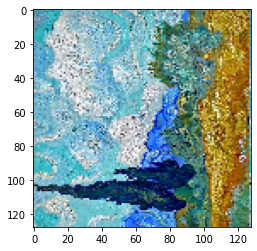

In [0]:
import pandas as pd
from torchvision import datasets, transforms,models


class DatasetMNIST(Dataset):
    
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        image = self.data.iloc[index, 1:].values.reshape((3, 128, 128))
        label = self.data.iloc[index, 0]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

train_dataset = DatasetMNIST('drive/Shared drives/503 Project/image_test_128.csv', transform=None)
img, lab = train_dataset.__getitem__(5)
img_t = img.transpose((1, 2, 0))
plt.imshow(img_t)




Read 128*128 data and do XGboost and adaboost

In [0]:
# Load libraries
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets
# Import train_test_split function
from sklearn.model_selection import train_test_split
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Import Support Vector Classifier
from sklearn.svm import SVC
svc=SVC(probability=True, kernel='linear')

import pandas as pd

In [0]:
#data_test = pd.read_csv('drive/Shared drives/503 Project/image_test_128.csv')
#data_test2 = pd.read_csv('drive/Shared drives/503 Project/image_test.csv')
n = len(data_test.iloc[2,:])
test_image = data_test.iloc[:, 0:n-1].values
test_label = data_test.iloc[:, n-1].values

In [0]:
#data_train = pd.read_csv('drive/Shared drives/503 Project/image_train_128.csv')
#data_train2 = pd.read_csv('drive/Shared drives/503 Project/image_train.csv')

train_image = data_train.iloc[:, 0:n-1].values
train_label = data_train.iloc[:, n-1].values

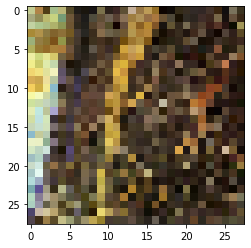

In [30]:
image = data_train2.iloc[199, 0:n-1].values.reshape((3, 28, 28))
img_t = image.transpose((1, 2, 0))
plt.imshow(img_t)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


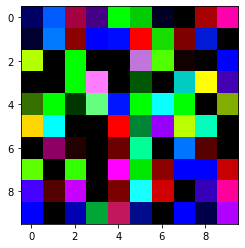

In [31]:
image = X_train[199,:].reshape((3, 10, 10))
img_t = image.transpose((1, 2, 0))
plt.imshow(img_t)

In [62]:
28*28*3

2352

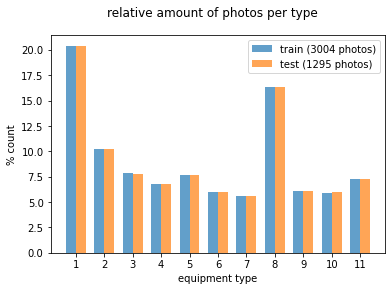

In [0]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
 
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
 
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
 
    xtemp = np.arange(len(unique))
 
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of photos per type')
plot_bar(train_label, loc='left')
plot_bar(test_label, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(train_label)),
    'test ({0} photos)'.format(len(test_label))
]);

Normalize the data

In [0]:
# Use sklearn StandardScaler to scale pixel values
from sklearn.preprocessing import StandardScaler
# Create scale object
scaler = StandardScaler()
# Fit scaler to training data only
scaler_fit = scaler.fit(train_image)
# Transform both train and test data with the trained scaler
X_train = scaler_fit.transform(train_image)
X_test = scaler_fit.transform(test_image)

In [0]:
X_train[0:100,:]

Do PCA to reduce dimensions

In [20]:
from sklearn.decomposition import PCA, KernelPCA

n_comp = 10*10*3
# PCA
print('\nRunning PCA ...')

#pca = KernelPCA(kernel="rbf")
pca = PCA(n_components=n_comp, svd_solver='full', random_state=1001)
X_pca = pca.fit(X_train[0:1000,:])
#print('Explained variance: %.4f' % pca.explained_variance_ratio_.sum())

#print('Individual variance contributions:')
#for j in range(n_comp):
#    print(pca.explained_variance_ratio_[j])


Running PCA ...


In [0]:
#pca.n_components
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [41]:
len(X_test[1,:])

1577

XGBoost

In [42]:
import xgboost as xgb
from sklearn.metrics import f1_score, accuracy_score


xgb_clf = xgb.XGBClassifier(random_state=1, learning_rate=0.5, max_depth=4, gamma = 0.1, objective = "multi:softmax")
xgb_model = xgb_clf.fit(X_train, train_label)
y_train_preds = xgb_model.predict(X_train)
y_test_preds = xgb_model.predict(X_test)
print("Training F1 Micro Average: ", f1_score(train_label, y_train_preds, average = "micro"))
print("Test F1 Micro Average: ", f1_score(test_label, y_test_preds, average = "micro"))
print("Test Accuracy: ", accuracy_score(test_label, y_test_preds))

Training F1 Micro Average:  1.0
Test F1 Micro Average:  0.16293436293436295
Test Accuracy:  0.16293436293436295


In [0]:
len(X_train[0,:])

2351

In [43]:
svc = SVC(kernel="linear", max_iter=200, decision_function_shape="ovo", random_state=1,probability=True )
svc_model = svc.fit(X_train, train_label)
y_train_preds = svc_model.predict(X_train)
y_test_preds = svc_model.predict(X_test)
print("Training F1 Micro Average: ", f1_score(train_label, y_train_preds, average = "micro"))
print("Test F1 Micro Average: ", f1_score(test_label, y_test_preds, average = "micro"))
print("Test Accuracy: ", accuracy_score(test_label, y_test_preds))

Training F1 Micro Average:  0.24833555259653795
Test F1 Micro Average:  0.16293436293436295
Test Accuracy:  0.16293436293436295


In [21]:
xgb_clf = xgb.XGBClassifier(random_state=1, learning_rate=0.5, max_depth=2, gamma = 0.1, objective = "multi:softmax")

eval_set = [(X_train, train_label), (X_test, test_label)]
xgb_clf.fit(X_train, train_label, eval_metric="merror", eval_set=eval_set, verbose=True)

[0]	validation_0-merror:0.404461	validation_1-merror:0.89807
[1]	validation_0-merror:0.356858	validation_1-merror:0.89807
[2]	validation_0-merror:0.318242	validation_1-merror:0.89807
[3]	validation_0-merror:0.293941	validation_1-merror:0.89807
[4]	validation_0-merror:0.274967	validation_1-merror:0.89807
[5]	validation_0-merror:0.259654	validation_1-merror:0.89807
[6]	validation_0-merror:0.242676	validation_1-merror:0.89807
[7]	validation_0-merror:0.235686	validation_1-merror:0.89807
[8]	validation_0-merror:0.217044	validation_1-merror:0.89807
[9]	validation_0-merror:0.200067	validation_1-merror:0.89807
[10]	validation_0-merror:0.188415	validation_1-merror:0.89807
[11]	validation_0-merror:0.172437	validation_1-merror:0.89807
[12]	validation_0-merror:0.156125	validation_1-merror:0.89807
[13]	validation_0-merror:0.144807	validation_1-merror:0.89807
[14]	validation_0-merror:0.139481	validation_1-merror:0.89807
[15]	validation_0-merror:0.129161	validation_1-merror:0.89807
[16]	validation_0-

KeyboardInterrupt: ignored

In [0]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=None, max_features = 25,  min_samples_split=2, random_state=0)
rf_model = rf_clf.fit(X_train, train_label)
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

print("Training F1 Micro Average: ", f1_score(train_label, y_train_preds, average = "micro"))
print("Test F1 Micro Average: ", f1_score(test_label, y_test_preds, average = "micro"))
print("Test Accuracy: ", accuracy_score(test_label, y_test_preds))

Training F1 Micro Average:  1.0
Test F1 Micro Average:  0.5173745173745173
Test Accuracy:  0.5173745173745173


In [0]:
from sklearn.linear_model import SGDClassifier


sgd_clf = SGDClassifier(random_state=42, max_iter=3000, tol=1e-7, l1_ratio=0.001)
sgd_model = sgd_clf.fit(X_train, train_label)

y_train_preds = sgd_model.predict(X_train)
y_test_preds = sgd_model.predict(X_test)
print("Training F1 Micro Average: ", f1_score(train_label, y_train_preds, average = "micro"))
print("Test F1 Micro Average: ", f1_score(test_label, y_test_preds, average = "micro"))
print("Test Accuracy: ", accuracy_score(test_label, y_test_preds))


Training F1 Micro Average:  0.5126498002663116
Test F1 Micro Average:  0.3752895752895753
Test Accuracy:  0.3752895752895753


In [0]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(max_depth=None, min_samples_split=3, random_state=0)
dt_model = dt_clf.fit(X_train, train_label)
y_train_preds = dt_model.predict(X_train)
y_test_preds = dt_model.predict(X_test)

print("Training F1 Micro Average: ", f1_score(train_label, y_train_preds, average = "micro"))
print("Test F1 Micro Average: ", f1_score(test_label, y_test_preds, average = "micro"))
print("Test Accuracy: ", accuracy_score(test_label, y_test_preds))

Training F1 Micro Average:  0.9550599201065246
Test F1 Micro Average:  0.2888030888030888
Test Accuracy:  0.2888030888030888


In [0]:
et_clf = ExtraTreesClassifier(n_estimators=50, max_features=45, min_samples_leaf=3, criterion="gini", min_samples_split=3, max_depth=23, random_state=0)
et_model = et_clf.fit(X_train, train_label)
y_train_preds = et_model.predict(X_train)
y_test_preds = et_model.predict(X_test)

print("Training F1 Micro Average: ", f1_score(train_label, y_train_preds, average = "micro"))
print("Test F1 Micro Average: ", f1_score(test_label, y_test_preds, average = "micro"))
print("Test Accuracy: ", accuracy_score(test_label, y_test_preds))

Training F1 Micro Average:  0.9996671105193076
Test F1 Micro Average:  0.47953667953667956
Test Accuracy:  0.47953667953667956


In [0]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb_clf, X_train, train_label, cv=5)
scores.mean()

0.4111236827509706

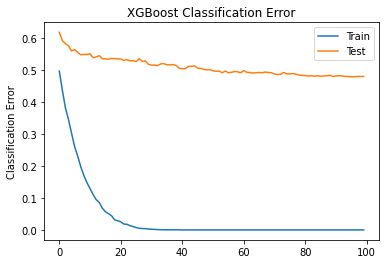

In [0]:
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [0]:
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=100,base_estimator=svc,learning_rate=0.1)

# Train Adaboost Classifer
model_adb = abc.fit(X_train, train_label)


#Predict the response for test dataset
y_pred = model_adb.predict(X_test)


In [0]:
print("Test F1 Micro Average: ", f1_score(test_label, y_pred, average = "micro"))
print("Test Accuracy: ", accuracy_score(test_label, y_pred))

Test F1 Micro Average:  0.2517374517374517
Test Accuracy:  0.2517374517374517
